 #  A Whale off the Port(folio)
 ---

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500 Index.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path

%matplotlib inline

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:

* `whale_returns.csv`: Contains returns of some famous "whale" investors' portfolios.

* `algo_returns.csv`: Contains returns from the in-house trading algorithms from Harold's company.

* `sp500_history.csv`: Contains historical closing prices of the S&P 500 Index.

## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [2]:
# Reading whale returns
whale = pd.read_csv("Resources/whale_returns.csv")
whale.sample(5)

,Date,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
664,2017-10-03,0.002102,-0.001288,0.003404,0.007965
94,2015-07-14,0.004872,0.004467,0.002888,0.001856
229,2016-01-21,0.008036,0.002368,0.019821,-0.008080
296,2016-04-26,0.002614,-0.003783,0.001361,-0.016557
621,2017-08-02,-0.003726,-0.009155,0.001075,-0.007844


In [3]:
# Count nulls
whale.isnull().sum()

Date                           0
SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [4]:
# Drop nulls
whale = whale.dropna(how='any', axis=0)
whale['Date']  = pd.to_datetime(whale['Date'])

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [5]:
# Reading algorithmic returns
algo = pd.read_csv("Resources/algo_returns.csv")
algo.sample(5)

,Date,Algo 1,Algo 2
185,2015-02-20,-0.002066,0.000996
1076,2018-09-04,-0.000860,-0.002850
838,2017-09-22,0.001891,0.003586
1144,2018-12-11,-0.008391,-0.002542
560,2016-08-16,-0.001068,-0.007262


In [6]:
# Count nulls
algo.isnull().sum()

Date      0
Algo 1    0
Algo 2    6
dtype: int64

In [7]:
# Drop nulls
algo = algo.dropna(how='any', axis=0)
algo["Date"] = pd.to_datetime(algo["Date"])

## S&P 500 Returns

Read the S&P 500 historic closing prices and create a new daily returns DataFrame from the data. 

In [8]:
# Reading S&P 500 Closing Prices
sp = pd.read_csv("Resources/sp500_history.csv")
sp.sample(5)

,Date,Close
1319,24-Jan-14,$1790.29
296,15-Feb-18,$2731.20
1541,8-Mar-13,$1551.18
1173,22-Aug-14,$1988.40
932,7-Aug-15,$2077.57


In [9]:
# Check Data Types
sp.dtypes

Date     object
Close    object
dtype: object

In [10]:
# Fix Data Types
sp['Date']  = pd.to_datetime(sp['Date'])
sp['Close'] = sp['Close'].str.replace("$", "").astype(float).round(2)
sp.dtypes

/tmp/ipykernel_72540/178641316.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp['Date']  = pd.to_datetime(sp['Date'])


Date     datetime64[ns]
Close           float64
dtype: object

In [11]:
# Calculate Daily Returns
sp["daily_returns"] = sp["Close"].pct_change(-1)

In [12]:
# Drop nulls
sp.isnull().sum()
sp = sp.dropna(how='any', axis=0)


In [13]:
# Rename `Close` Column to be specific to this portfolio.
sp.columns
sp.columns = ["Date", "sp500_price", "sp500_daily_returns"]

## Combine Whale, Algorithmic, and S&P 500 Returns

In [14]:
# Join Whale Returns, Algorithmic Returns, and the S&P 500 Returns into a single DataFrame with columns for each portfolio's returns.
prev = pd.merge(whale, algo, how="outer", on=["Date"])
all = pd.merge(prev, sp, how="outer", on=["Date"])
returns = all[["Date", "SOROS FUND MANAGEMENT LLC", "PAULSON & CO.INC. ", "TIGER GLOBAL MANAGEMENT LLC", "BERKSHIRE HATHAWAY INC", "Algo 1", "Algo 2", "sp500_daily_returns"]]

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance Anlysis

#### Calculate and Plot the daily returns.

<Axes: xlabel='Date'>

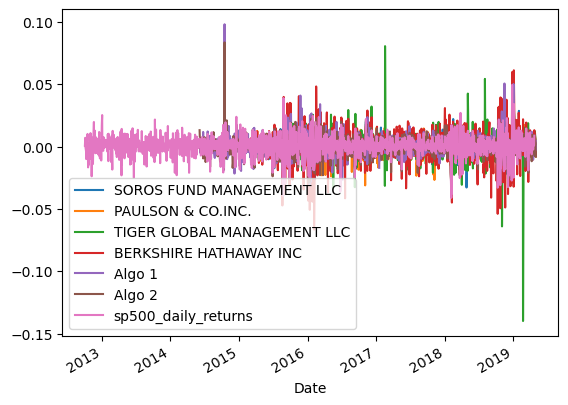

In [15]:
# Plot daily returns of all portfolios
returns.set_index("Date", inplace=True)
returns.plot()

#### Calculate and Plot cumulative returns.

<Axes: xlabel='Date'>

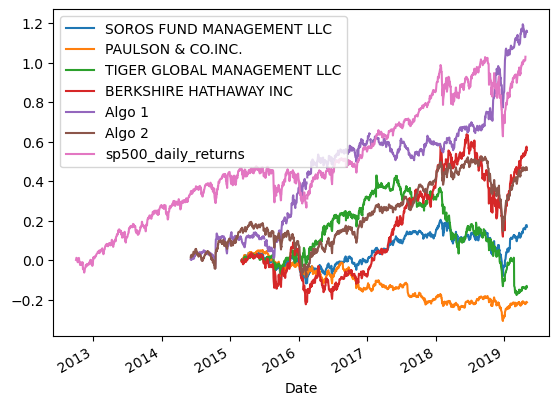

In [16]:
# Calculate cumulative returns of all portfolios
cumulative_returns = pd.DataFrame()
fund_list = ["SOROS FUND MANAGEMENT LLC", "PAULSON & CO.INC. ", "TIGER GLOBAL MANAGEMENT LLC", "BERKSHIRE HATHAWAY INC", "Algo 1", "Algo 2", "sp500_daily_returns"]
for fund in fund_list: 
   cumulative_returns[fund] = (1 + returns[fund]).cumprod() - 1 

# Plot cumulative returns
cumulative_returns.plot()

---

## Risk Analysis

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

### Create a box plot for each portfolio


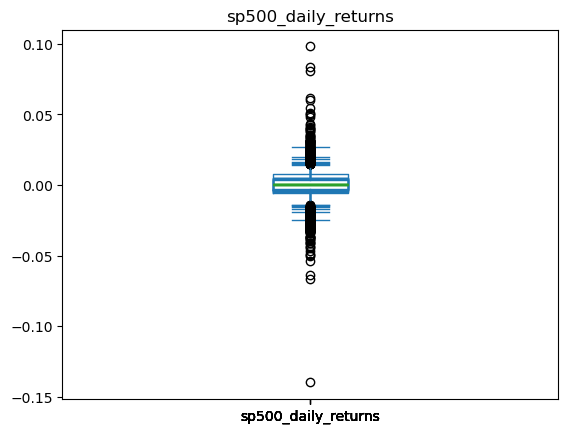

In [17]:
# Box plot to visually show risk
for fund in fund_list:
    returns[fund].plot(kind="box", title = fund)

### Calculate Standard Deviations

In [18]:
# Calculate the daily standard deviations of all portfolios
stds = returns.std()

### Determine which portfolios are riskier than the S&P 500

In [19]:
# Calculate  the daily standard deviation of S&P 500
spstd = stds['sp500_daily_returns']
# Determine which portfolios are riskier than the S&P 500
for s in stds:
    if s > spstd:
        print(stds[stds==s].index)

Index(['TIGER GLOBAL MANAGEMENT LLC'], dtype='object')
Index(['BERKSHIRE HATHAWAY INC'], dtype='object')
Index(['Algo 2'], dtype='object')


### Calculate the Annualized Standard Deviation

In [20]:
# Calculate the annualized standard deviation (252 trading days)
import math
for s in stds:
    print(stds[stds==s].index,": ", s * math.sqrt(252))

Index(['SOROS FUND MANAGEMENT LLC'], dtype='object') :  0.12448731354980655
Index(['PAULSON & CO.INC. '], dtype='object') :  0.11075440057593401
Index(['TIGER GLOBAL MANAGEMENT LLC'], dtype='object') :  0.17183018551589085
Index(['BERKSHIRE HATHAWAY INC'], dtype='object') :  0.20368211940022282
Index(['Algo 1'], dtype='object') :  0.12680100939038405
Index(['Algo 2'], dtype='object') :  0.13440092036178766
Index(['sp500_daily_returns'], dtype='object') :  0.1287624241367024


---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for all portfolios using a 21-day window
2. Calculate the correlation between each stock to determine which portfolios may mimick the S&P 500
3. Choose one portfolio, then calculate and plot the 60-day rolling beta between it and the S&P 500

### Calculate and plot rolling `std` for all portfolios with 21-day window

<Axes: xlabel='Date'>

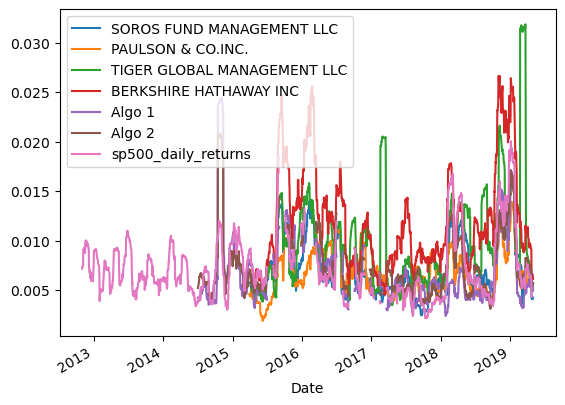

In [21]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
window = 21
rolling_stds = pd.DataFrame()
for fund in fund_list:
    rolling_stds[fund] = returns[fund].rolling(window).std()
    
# Plot the rolling standard deviation
rolling_stds.plot()

### Calculate and plot the correlation

In [22]:
# Calculate the correlation
# Display de correlation matrix
returns.corr()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,sp500_daily_returns
SOROS FUND MANAGEMENT LLC,1.000000,0.700181,0.561745,0.754308,0.321366,0.826719,0.837864
PAULSON & CO.INC.,0.700181,1.000000,0.435333,0.545802,0.269257,0.677993,0.669732
TIGER GLOBAL MANAGEMENT LLC,0.561745,0.435333,1.000000,0.425102,0.164840,0.508139,0.623946
BERKSHIRE HATHAWAY INC,0.754308,0.545802,0.425102,1.000000,0.292307,0.687717,0.751371
Algo 1,0.321366,0.269257,0.164840,0.292307,1.000000,0.346568,0.264393
Algo 2,0.826719,0.677993,0.508139,0.687717,0.346568,1.000000,0.821981
sp500_daily_returns,0.837864,0.669732,0.623946,0.751371,0.264393,0.821981,1.000000


### Calculate and Plot Beta for a chosen portfolio and the S&P 500

In [23]:
# Calculate covariance of a single portfolio
cov = returns["sp500_daily_returns"].cov(returns['Algo 1'])
# Calculate variance of S&P 500
spvar = returns["sp500_daily_returns"].var()
# Computing beta
beta = cov/spvar
# Plot beta trend

## Rolling Statistics Challenge: Exponentially Weighted Average 

An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the [`ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) with a 21-day half life for each portfolio, using standard deviation (`std`) as the metric of interest.

In [24]:
# Use `ewm` to calculate the rolling window
e = returns.ewm(halflife=21)
print(e)

ExponentialMovingWindow [halflife=21,min_periods=1,adjust=True,ignore_na=False,axis=0,method=single]


---

# Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. After all, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, you'd take that one, right?

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [25]:
# Annualized Sharpe Ratios

# choosing risk free rate of 2%
ratios = []
for fund in fund_list:
    annualized_mean_return = returns[fund].mean() * 252
    annualized_std = returns[fund].std() * math.sqrt(252)
    ratios.append({"Name": fund, "Sharpe Ratio": (annualized_mean_return - 0.02) / annualized_std})

sharpe = pd.DataFrame(ratios)

sharpe.head()

,Name,Sharpe Ratio
0,SOROS FUND MANAGEMENT LLC,0.200909
1,PAULSON & CO.INC.,-0.642711
2,TIGER GLOBAL MANAGEMENT LLC,-0.234651
3,BERKSHIRE HATHAWAY INC,0.521435
4,Algo 1,1.142449


<Axes: xlabel='Name'>

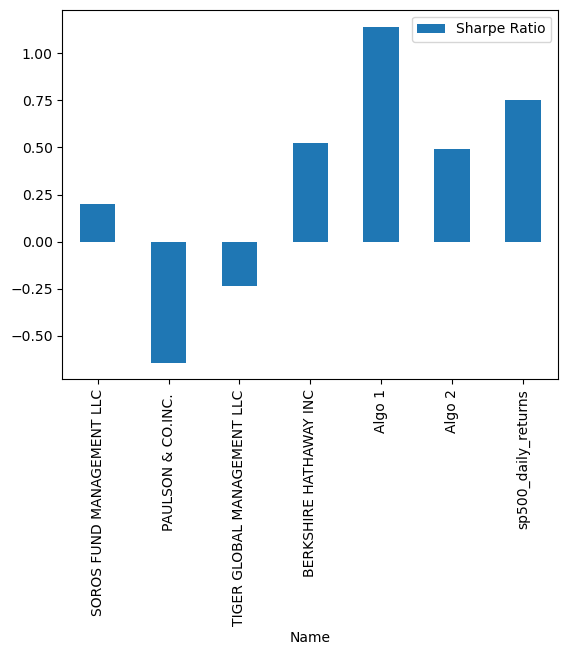

In [26]:
# Visualize the sharpe ratios as a bar plot
sharpe.plot(kind='bar', x = "Name")

### Determine whether the algorithmic strategies outperform both the market (S&P 500) and the whales portfolios.

It appears that algo 1 does quite well. It has the highest Sharpe ratio and returns roughly on par with the S&P 500.

---

# Create Custom Portfolio

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others
5. Include correlation analysis to determine which stocks (if any) are correlated

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [27]:
# Reading data from 1st stock
aapl = pd.read_csv("Resources/aapl_historical.csv")

In [28]:
# Reading data from 2nd stock
goog = pd.read_csv("Resources/goog_historical.csv")

In [29]:
# Reading data from 3rd stock
cost = pd.read_csv("Resources/cost_historical.csv")

In [30]:
# Combine all stocks in a single DataFrame
ag = pd.merge(aapl, goog, how="outer", on=["Trade DATE", "Symbol", "NOCP"])
all_stocks = pd.merge(ag, cost, how="outer", on=["Trade DATE", "Symbol", "NOCP"])

In [31]:
# Reset Date index
all_stocks["Trade DATE"] = pd.to_datetime(all_stocks['Trade DATE'])
all_stocks.set_index("Trade DATE", inplace=True)


In [32]:
# Reorganize portfolio data by having a column per symbol
all_stocks.head()
final = all_stocks.pivot(columns="Symbol", values="NOCP")
final.dtypes

Symbol
AAPL    float64
COST    float64
GOOG    float64
dtype: object

In [33]:
# Calculate daily returns
stock_returns = final.pct_change()
# Drop NAs
stock_returns = stock_returns.dropna(how='any', axis=0)
# Display sample data
stock_returns.sample(10)


Symbol,AAPL,COST,GOOG
Trade DATE,,,
2019-04-10,0.005614,0.002858,0.004101
2018-10-26,-0.015924,-0.036263,-0.021998
2019-01-10,0.003196,0.003525,-0.004029
2019-02-07,-0.018939,-0.012051,-0.014813
2018-05-16,0.009333,0.016523,0.002354
2018-06-26,0.012406,-0.007839,-0.005645
2018-09-12,-0.012419,-0.007248,-0.012350
2019-04-05,0.006694,0.006015,-0.006461
2019-03-29,0.006518,0.003814,0.004125


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [34]:
# Set weights
weights = [1/3, 1/3, 1/3]

# Calculate portfolio return
stock_returns['weighted_return'] = stock_returns.iloc[:, 0:].dot(weights)
# Display sample data
stock_returns.sample(10)

Symbol,AAPL,COST,GOOG,weighted_return
Trade DATE,,,,
2019-04-29,0.001517,0.001887,0.012105,0.005170
2018-12-10,0.006588,-0.009784,0.002865,-0.000110
2018-11-26,0.013524,-0.002772,0.024163,0.011638
2019-03-28,0.001326,0.007560,-0.003862,0.001675
2018-07-13,0.001570,0.011775,0.004512,0.005952
2019-01-23,0.004044,-0.001460,0.004717,0.002434
2018-08-21,-0.001949,0.005234,-0.005092,-0.000602
2018-11-14,-0.028247,-0.003545,0.007345,-0.008149
2018-11-09,-0.019282,-0.004022,-0.015013,-0.012772


## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [35]:
# Join your returns DataFrame to the original returns DataFrame
final_returns = pd.merge(returns, stock_returns, left_index=True, right_index=True)

In [36]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
final_returns_clean = final_returns.dropna(how='any', axis=0)
fund_list.append("weighted_return")

final_returns_clean = final_returns_clean[fund_list]
final_returns_clean.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,sp500_daily_returns,weighted_return
2018-05-14,0.000000,0.000000,0.000000,0.000000,0.000915,0.001635,0.000884,0.000015
2018-05-15,-0.000726,-0.001409,-0.003189,-0.014606,-0.001135,-0.001139,-0.006842,-0.010064
2018-05-16,0.008637,0.006244,0.005480,0.004310,-0.002326,0.003341,0.004061,0.009403
2018-05-17,-0.001955,0.002524,-0.006267,-0.005140,-0.006949,0.005205,-0.000856,-0.001595
2018-05-18,-0.004357,-0.002672,-0.012832,-0.002212,0.002557,-0.002496,-0.002632,-0.006061


## Re-run the risk analysis with your portfolio to see how it compares to the others

### Calculate the Annualized Standard Deviation

In [37]:
# Calculate the annualized `std`
for fund in fund_list:
    annualized_std = final_returns_clean[fund].std() * math.sqrt(252)


### Calculate and plot rolling `std` with 21-day window

<Axes: >

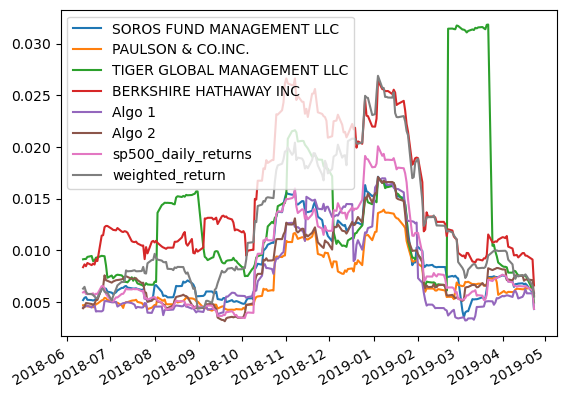

In [38]:
# Calculate rolling standard deviation
window = 21
rolling_stds_new = pd.DataFrame()
for fund in fund_list:
    rolling_stds_new[fund] = final_returns_clean[fund].rolling(window).std()
    
# Plot the rolling standard deviation
rolling_stds_new.plot()

### Calculate and plot the correlation

<Axes: >

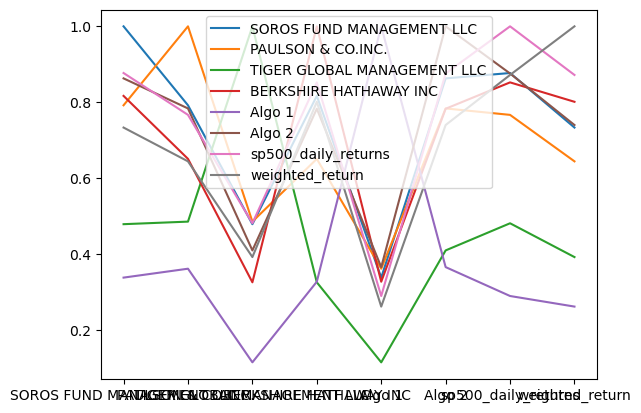

In [39]:
# Calculate and plot the correlation
corrs_clean = final_returns_clean.corr()
corrs_clean.plot()

### Calculate and Plot Rolling 60-day Beta for Your Portfolio compared to the S&P 500

<Axes: >

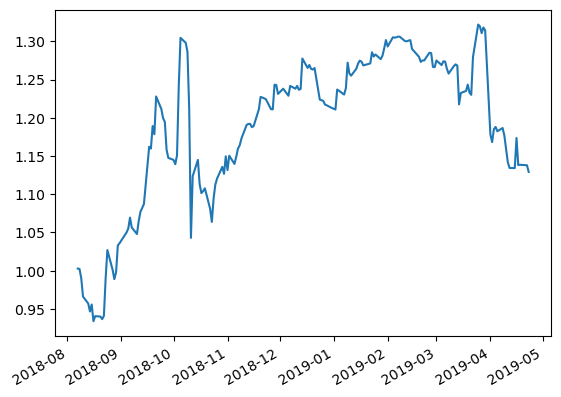

In [40]:
# Calculate and plot Beta

rolling_cov = final_returns_clean['weighted_return'].rolling(60).cov(final_returns_clean['sp500_daily_returns'])
rolling_var = final_returns_clean['sp500_daily_returns'].rolling(60).var()
rolling_beta = rolling_cov / rolling_var

rolling_beta.plot()

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [41]:
# Calculate Annualized Sharpe Ratios
# choosing risk free rate of 2%
ratios = []
for fund in fund_list:
    annualized_mean_return = final_returns_clean[fund].mean() * 252
    annualized_std = final_returns_clean[fund].std() * math.sqrt(252)
    ratios.append({"Name": fund, "Sharpe Ratio": (annualized_mean_return - 0.02) / annualized_std})

sharpe_new = pd.DataFrame(ratios)

<Axes: xlabel='Name'>

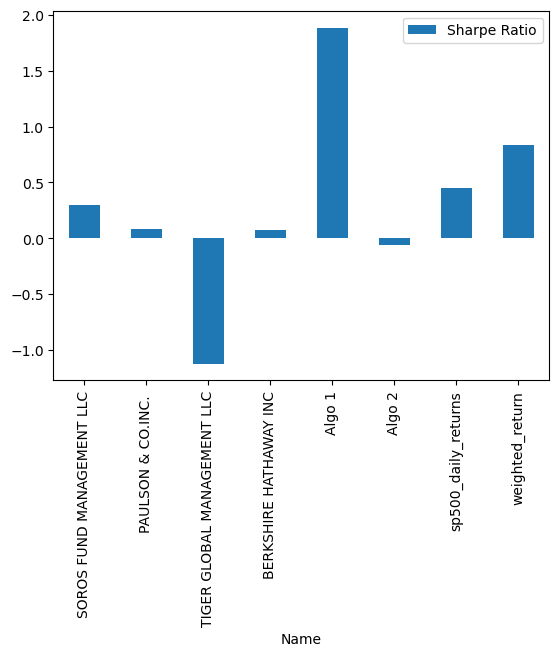

In [42]:
# Visualize the sharpe ratios as a bar plot
sharpe_new.plot(kind='bar', x = "Name")

### How does your portfolio do?

Write your answer here!

In [ ]:
Looks like we didn't do half bad! Our portfolio has a higher sharpe ratio then the s&p